In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

#from feature_engine.categorical_encoders import MeanCategoricalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
import sklearn
import xgboost
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Using TensorFlow backend.


In [2]:
df=pd.read_csv('dataset.csv')
df.head()

dteday  season  hr  holiday   weekday  workingday weathersit  temp  \
0  2011-01-01  spring   0        0  Saturday           0      Clear  0.24   
1  2011-01-01  spring   1        0  Saturday           0      Clear  0.22   
2  2011-01-01  spring   2        0  Saturday           0      Clear  0.22   
3  2011-01-01  spring   3        0  Saturday           0      Clear  0.24   
4  2011-01-01  spring   4        0  Saturday           0      Clear  0.24   

    atemp   hum  windspeed  cnt  
0  0.2879  0.81        0.0   16  
1  0.2727  0.80        0.0   40  
2  0.2727  0.80        0.0   32  
3  0.2879  0.75        0.0   13  
4  0.2879  0.75        0.0    1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
dteday        17379 non-null object
season        17379 non-null object
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null object
workingday    17379 non-null int64
weathersit    17379 non-null object
temp          17369 non-null float64
atemp         17379 non-null float64
hum           17366 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.6+ MB


In [4]:
#covert dteday to datetime type
df['dteday']=pd.to_datetime(df['dteday'])
print('date min & max: ', df['dteday'].min(), df['dteday'].max())
print('total days: ', df['dteday'].nunique())

date min & max:  2011-01-01 00:00:00 2012-12-31 00:00:00
total days:  731


# EDA, Feature Engineering & Selection

In [5]:
#some stats which indicates that data is normalized/clipped
df.describe()

hr       holiday    workingday          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17369.000000  17379.000000   
mean      11.546752      0.028770      0.682721      0.497035      0.475775   
std        6.914405      0.167165      0.465431      0.192589      0.171850   
min        0.000000      0.000000      0.000000      0.020000      0.000000   
25%        6.000000      0.000000      0.000000      0.340000      0.333300   
50%       12.000000      0.000000      1.000000      0.500000      0.484800   
75%       18.000000      0.000000      1.000000      0.660000      0.621200   
max       23.000000      1.000000      1.000000      1.000000      1.000000   

                hum     windspeed           cnt  
count  17366.000000  17379.000000  17379.000000  
mean       0.627176      0.190098    189.463088  
std        0.192921      0.122340    181.387599  
min        0.000000      0.000000      1.000000  
25%        0.480000      0.104500     40.000000  
50%        0.630000      0.194000    142.000000  
75%        0.780000      0.253700    281.000000  
max        1.000000      0.850700    977.000000

In [6]:
#check for % missing
df.isnull().mean()

dteday        0.000000
season        0.000000
hr            0.000000
holiday       0.000000
weekday       0.000000
workingday    0.000000
weathersit    0.000000
temp          0.000575
atemp         0.000000
hum           0.000748
windspeed     0.000000
cnt           0.000000
dtype: float64

In [7]:
#some EDA before doing any processing
pandas_profiling.ProfileReport(df)

In [7]:
#let's create extract more time features form date column and drop and then dorp it
df["day"] = df["dteday"].dt.day
df["month"] = df["dteday"].dt.month

df.drop('dteday',inplace=True, axis=1 )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
season        17379 non-null object
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null object
workingday    17379 non-null int64
weathersit    17379 non-null object
temp          17369 non-null float64
atemp         17379 non-null float64
hum           17366 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
day           17379 non-null int64
month         17379 non-null int64
dtypes: float64(4), int64(6), object(3)
memory usage: 1.7+ MB


In [9]:
#move the target to the very right of the df

col_at_end = ['cnt']

df = df[[c for c in df if c not in col_at_end] 
          + [c for c in col_at_end if c in df.columns]]

df.head(2)

season  hr  holiday   weekday  workingday weathersit  temp   atemp   hum  \
0  spring   0        0  Saturday           0      Clear  0.24  0.2879  0.81   
1  spring   1        0  Saturday           0      Clear  0.22  0.2727  0.80   

   windspeed  day  month  cnt  
0        0.0    1      1   16  
1        0.0    1      1   40

In [10]:
#some quick insights.
pandas_profiling.ProfileReport(df)

percentage of the cnt values less than 500:  0.92594510616261


Text(0.5, 0, 'cnt')

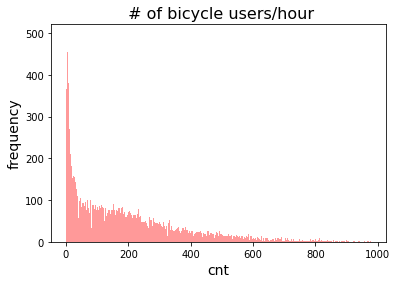

In [9]:
#target distribution
print('percentage of the cnt values less than 500: ', len(df[df['cnt']<500])/len(df))
sns.distplot(df['cnt'], kde=False, color='red', bins=500);

plt.title(' # of bicycle users/hour', size = 16);
plt.ylabel('frequency', size = 14)
plt.xlabel('cnt', size = 14)

In [10]:
#drop the temp as it has a huge correlation with atemp and would be redundant
df.drop('temp', inplace=True, axis=1)

In [13]:
#dropping the missing rows again
df.isnull().sum()

season         0
hr             0
holiday        0
weekday        0
workingday     0
weathersit     0
atemp          0
hum           13
windspeed      0
day            0
month          0
cnt            0
dtype: int64

In [11]:
#drop the missing rows as they are very small amount
df.dropna(inplace=True, axis=0)

# Encode the categorical variables: [weathersit, weekday, season]

In [15]:
# check for possible cardinality and rare types
print('weathersit: \n' ,df.weathersit.value_counts())
print('\n')

#1. weekday
print('weekday: \n' ,df.weekday.value_counts())
print('\n')

#1. season
print('season: \n' ,df.season.value_counts())

weathersit: 
 Clear              11404
Slightly cloudy     4541
Light Snow          1418
Thunderstorm           3
Name: weathersit, dtype: int64


weekday: 
 Saturday     2509
Sunday       2500
Friday       2486
Monday       2478
Wednesday    2474
Thursday     2468
Tuesday      2451
Name: weekday, dtype: int64


season: 
 fall      4491
summer    4407
spring    4239
winter    4229
Name: season, dtype: int64


In [12]:
#we drop Thunderstorm and encode the rest to avoid potential missing in the test or even production!
df=df[df['weathersit']!= 'Thunderstorm']

In [17]:
#check potential cardinality for hrs too just in case as hr has a strong correlation
df['hr'].astype('O').value_counts()

17    729
16    729
15    729
14    729
23    728
20    728
12    727
8     727
9     727
10    727
22    727
11    727
13    727
19    727
21    727
18    726
7     726
0     726
6     725
1     722
5     716
2     715
4     697
3     695
Name: hr, dtype: int64

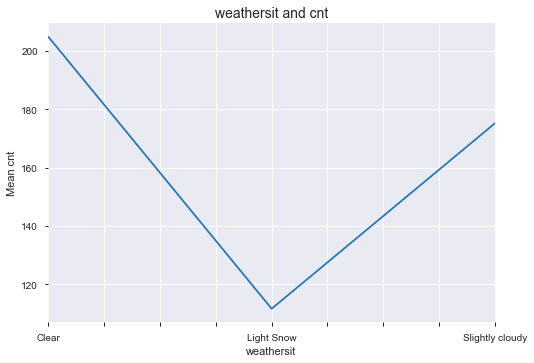

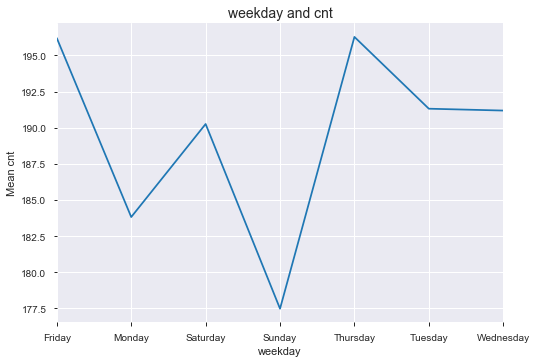

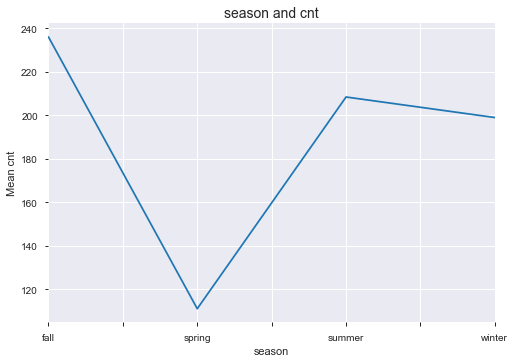

In [18]:
#investigate the relationship of the cat variables and cnt---it's not monotonic
for var in ['weathersit', 'weekday', 'season']:
    
    fig = plt.figure()
    fig = df.groupby([var])['cnt'].mean().plot()
    fig.set_title('{} and cnt'.format(var), size=14)
    fig.set_ylabel('Mean cnt')
    plt.show()

# Target Encoding

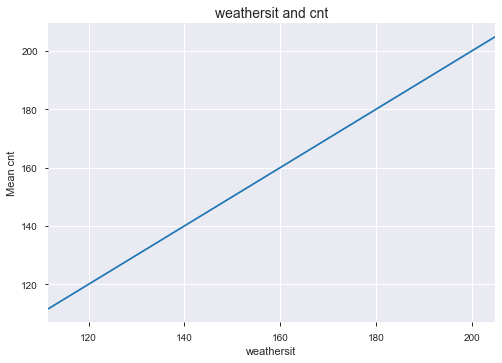

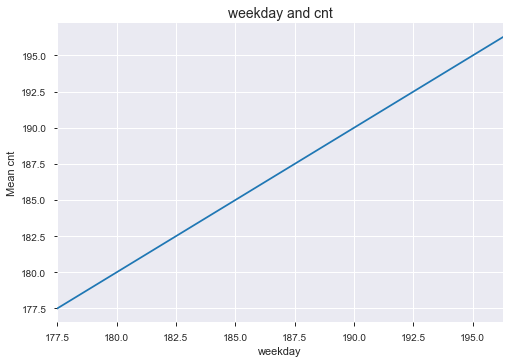

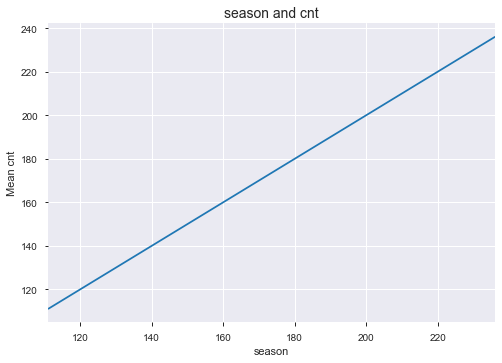

In [19]:
#target-encode and investigate the relationship again----it's now monotonic
df_temp=df.copy()
for variable in ['weathersit', 'weekday', 'season']:
    mappings = df_temp.groupby([variable])['cnt'].mean().to_dict()
    df_temp[variable] = df_temp[variable].map(mappings)
    
    fig = plt.figure()
    fig = df_temp.groupby([variable])['cnt'].mean().plot()
    fig.set_title('{} and cnt'.format(variable), size=14)
    fig.set_ylabel('Mean cnt')
    plt.show()

run this cell only if you want to targt-encode the cat variables

In [13]:
def Target_Enc (df):

    X_train, X_test, y_train, y_test = train_test_split(df,df['cnt'],  # keeping the target
    test_size=0.3)

    target = 'cnt'
    #run them through a loop
    for variable in ['weathersit', 'weekday', 'season']:
        mappings = df.groupby([variable])[target].mean().to_dict()
        X_train[variable] = X_train[variable].map(mappings)
        X_test[variable] = X_test[variable].map(mappings)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = Target_Enc(df)

X_train=X_train.iloc[:, :-1].values #drop the target
X_test=X_test.iloc[:, :-1].values

X_train.shape, X_test.shape

/Users/asadmolayari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/asadmolayari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


((12154, 11), (5209, 11))

# One Hot Encoding

run this cell only if you want to one-hot encode the cat variables

In [21]:
def OH_Enc(df):

    X_train, X_test, y_train, y_test = train_test_split(
    df.drop('cnt', axis=1),
    df['cnt'],  # target
    test_size=0.3)
    
    X_train = pd.concat(
        [X_train[['hr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'day', 'month']],
         pd.get_dummies(X_train[['weathersit', 'weekday', 'season']], drop_first=True)],
        axis=1)
    
    X_test = pd.concat(
        [X_test[['hr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'day', 'month']],
         pd.get_dummies(X_test[['weathersit', 'weekday', 'season']], drop_first=True)],
        axis=1)

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = OH_Enc(df)

X_train=X_train.iloc[:, :].values
X_test=X_test.iloc[:, :].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12154, 19), (5209, 19), (12154,), (5209,))

# Build Models

Four models are built, SVM, Random Forest, XGBoost and Deep Learning

# SVM

In [22]:
np.array([y_train]).T.shape

(12154, 1)

In [23]:
print('shapes: ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#scaling the features. Linear models will benefit from. 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape, X_test.shape

from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)


shapes:  (12154, 19) (5209, 19) (12154,) (5209,)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

MAE:  100.78
RMSE:  154.66
R2:  0.27


Text(0.5, 0, ' # of actual bicycle users/hour')

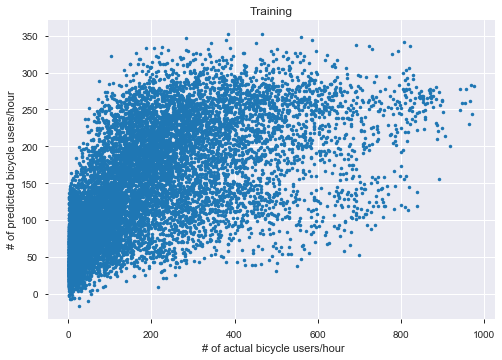

In [24]:
#on the training
y_pred = regressor.predict(X_train)

print("MAE: ", round(mean_absolute_error(y_train, y_pred),2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_train, y_pred)),2))
print("R2: ", round(r2_score(y_train, y_pred),2))
plt.plot(y_train, y_pred, '.')
plt.title('Training')
plt.ylabel(' # of predicted bicycle users/hour')
plt.xlabel(' # of actual bicycle users/hour')

MAE:  100.05
RMSE:  152.81
R2:  0.29


Text(0.5, 0, ' # of actual bicycle users/hour')

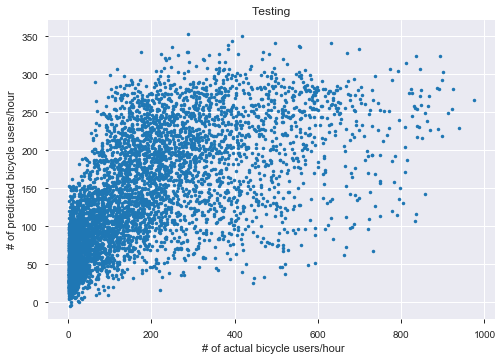

In [25]:
#on the test
y_pred = regressor.predict(X_test)

print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
print("R2: ", round(r2_score(y_test, y_pred),2))
plt.plot(y_test, y_pred, '.')
plt.title('Testing')
plt.ylabel(' # of predicted bicycle users/hour')
plt.xlabel(' # of actual bicycle users/hour')

# Random Forest

In [26]:
print('shapes: ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200)
regressor.fit(X_train, y_train)

shapes:  (12154, 19) (5209, 19) (12154,) (5209,)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

MAE:  16.2
RMSE:  24.77
R2:  0.98


Text(0.5, 0, ' # of actual bicycle users/hour')

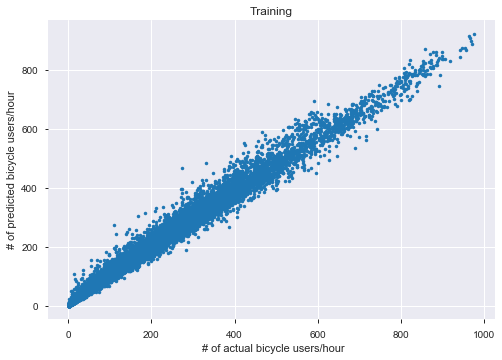

In [27]:
#on the train data
y_pred = regressor.predict(X_train)

print("MAE: ", round(mean_absolute_error(y_train, y_pred),2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_train, y_pred)),2))
print("R2: ", round(r2_score(y_train, y_pred),2))
plt.plot(y_train, y_pred, '.')
plt.title('Training')
plt.ylabel(' # of predicted bicycle users/hour')
plt.xlabel(' # of actual bicycle users/hour')

MAE:  43.24
RMSE:  66.29
R2:  0.87


Text(0.5, 0, ' # of actual bicycle users/hour')

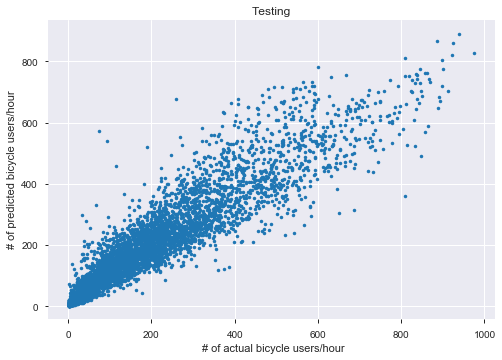

In [28]:
#on the test
y_pred = regressor.predict(X_test)

print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
print("R2: ", round(r2_score(y_test, y_pred),2))
plt.plot(y_test, y_pred, '.')
plt.title('Testing')
plt.ylabel(' # of predicted bicycle users/hour')
plt.xlabel(' # of actual bicycle users/hour')

# XGBoost

In [24]:
print('shapes: ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from xgboost import XGBRegressor
regressor = XGBRegressor(max_depth=5,
    learning_rate=0.1,
    n_estimators=300)
regressor.fit(X_train, y_train)

shapes:  (12154, 11) (5209, 11) (12154,) (5209,)
[12:17:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/asadmolayari/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

MAE:  35.13
RMSE:  51.33
R2:  0.92


Text(0.5, 0, ' # of actual bicycle users/hour')

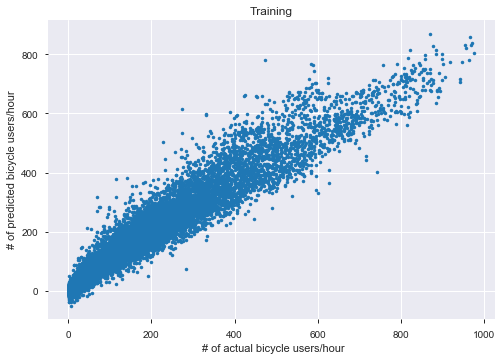

In [30]:
#on the train data
y_pred = regressor.predict(X_train)

print("MAE: ", round(mean_absolute_error(y_train, y_pred),2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_train, y_pred)),2))
print("R2: ", round(r2_score(y_train, y_pred),2))
plt.plot(y_train, y_pred, '.')
plt.title('Training')
plt.ylabel(' # of predicted bicycle users/hour')
plt.xlabel(' # of actual bicycle users/hour')

In [ ]:
#on the testing
y_pred = regressor.predict(X_test)

print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
print("R2: ", round(r2_score(y_test, y_pred),2))
plt.plot(y_test, y_pred, '.')
plt.title('Testing')
plt.ylabel(' # of predicted bicycle users/hour')
plt.xlabel(' # of actual bicycle users/hour')

# ANN

In [14]:
#scaling the features. ANN will benefit from

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape, X_test.shape

((12154, 11), (5209, 11))

In [23]:
model = Sequential()
model.add(Dense(units = 200, kernel_initializer = 'normal', activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(p=0.3))
model.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(p=0.3))
model.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(p=0.3))
model.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(p=0.3))
model.add(Dense(units = 1, kernel_initializer = 'normal'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size=None)

/Users/asadmolayari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.3)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/asadmolayari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.3)`
  """
/Users/asadmolayari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.3)`
  import sys
/Users/asadmolayari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.3)`
  if __name__ == '__main__':


Epoch 1/100
12154/12154 [==============================] - 2s 142us/step - loss: 15016.3407
Epoch 2/100
12154/12154 [==============================] - 1s 54us/step - loss: 3431.1846
Epoch 3/100
12154/12154 [==============================] - 1s 53us/step - loss: 3318.5806
Epoch 4/100
12154/12154 [==============================] - 1s 55us/step - loss: 3219.4195
Epoch 5/100
12154/12154 [==============================] - 1s 53us/step - loss: 3118.7165
Epoch 6/100
12154/12154 [==============================] - 1s 53us/step - loss: 3132.7942
Epoch 7/100
12154/12154 [==============================] - 1s 53us/step - loss: 3329.4710
Epoch 8/100
12154/12154 [==============================] - 1s 53us/step - loss: 3099.8334
Epoch 9/100
12154/12154 [==============================] - 1s 55us/step - loss: 3053.4199
Epoch 10/100
12154/12154 [==============================] - 1s 55us/step - loss: 3129.6477
Epoch 11/100
12154/12154 [==============================] - 1s 54us/step - loss: 2981.6035
Epoch 

12154/12154 [==============================] - 1s 52us/step - loss: 2322.7643
Epoch 92/100
12154/12154 [==============================] - 1s 56us/step - loss: 2239.6146
Epoch 93/100
12154/12154 [==============================] - 1s 51us/step - loss: 2240.0505
Epoch 94/100
12154/12154 [==============================] - 1s 79us/step - loss: 2207.2171
Epoch 95/100
12154/12154 [==============================] - 1s 51us/step - loss: 2282.4834
Epoch 96/100
12154/12154 [==============================] - 1s 46us/step - loss: 2187.6938
Epoch 97/100
12154/12154 [==============================] - 1s 53us/step - loss: 2191.9429
Epoch 98/100
12154/12154 [==============================] - 1s 54us/step - loss: 2339.2555
Epoch 99/100
12154/12154 [==============================] - 1s 55us/step - loss: 2224.2313
Epoch 100/100
12154/12154 [==============================] - 1s 74us/step - loss: 2265.1943


In [ ]:
#on the train data
y_pred = model.predict(X_train)

print("MAE: ", round(mean_absolute_error(y_train, y_pred),2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_train, y_pred)),2))
print("R2: ", round(r2_score(y_train, y_pred),2))
plt.plot(y_train, y_pred, '.')
plt.title('Training')
plt.ylabel(' # of predicted bicycle users/hour')
plt.xlabel(' # of actual bicycle users/hour')

In [ ]:
#on the testing
y_pred = model.predict(X_test)

print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
print("R2: ", round(r2_score(y_test, y_pred),2))
plt.plot(y_test, y_pred, '.')
plt.title('Testing')
plt.ylabel(' # of predicted bicycle users/hour')
plt.xlabel(' # of actual bicycle users/hour')